In [1]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2024-05-19 18:46:28.549092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:46:29.478348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:46:29.481118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 18:46:32.587849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Cargar el dataset desde train.csv
data = pd.read_csv('train.csv')
from spellchecker import SpellChecker
spell = SpellChecker()
import re
import emoji
import spacy

# Cargar el modelo de idioma inglés de spaCy
nlp = spacy.load("en_core_web_sm") 

# Función para preprocesar el texto
def preprocess_text(text):
    
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, 'URL', text)
    
    # Convertir emojis a palabras descriptivas
    text = emoji.demojize(text)
    
    # Reemplazar emojis desemojizados con guiones bajos por espacios
    emoji_pattern = r'\b(\w+(?:_\w+)*)\b'
    text = re.sub(emoji_pattern, lambda x: ' '.join(x.group(1).split('_')), text)

    # Reemplazar dos emojis juntos unidos por :: con un espacio entre ellos
    double_emoji_pattern = r'::'
    text = re.sub(double_emoji_pattern, ' ', text)
    
    # Eliminar símbolos '#' de los hashtags
    text = re.sub(r'#(\w+)', r'\1', text)
    '''
    # Tokenización y lematización
    doc = nlp(text)
    tokens_lemmatized = [token.lemma_ for token in doc] 
    
    # Eliminación de stopwords y caracteres especiales
    clean_tokens = [token.lower() for token in tokens_lemmatized
                    if not nlp.vocab[token].is_stop 
                    and nlp.vocab[token].is_oov
                    and not nlp.vocab[token].is_punct
                    and token.isalpha 
                   ]
    
    # Unir los tokens limpios en una cadena de texto nuevamente
    clean_text = " ".join(clean_tokens)
    '''
    return text

def correct_spelling(text):
    corrected_text = []
    words = text.split()
    for word in words:
        # Verificar si la palabra está mal escrita
        if spell.unknown([word]):
            # Corregir la palabra mal escrita
            corrected_word = spell.correction(word)
            if corrected_word:
                corrected_text.append(corrected_word)
            else:
                corrected_text.append(word)  # Conservar la palabra original si la corrección es None
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)


# Aplicar el preprocesamiento al texto
#data=data[0:50]
data['clean_text'] = data['text']#.apply(preprocess_text)
data.head()

data

/home/luis.castano.ortega/.local/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


,label,text,id,clean_text
0,0,"Hi Roy hope you are ok, Trans people are not g...",95e98db99c2,"Hi Roy hope you are ok, Trans people are not g..."
1,0,But fuckin' hell what even is biology,a87b8708e63,But fuckin' hell what even is biology
2,0,Whose the nice looking clergyman?,5b3cb03803f,Whose the nice looking clergyman?
3,1,"AIDS ARE IN YOUR WAY, SIN HAS CONSEQUENCES AND...",5b0bad2347e,"AIDS ARE IN YOUR WAY, SIN HAS CONSEQUENCES AND..."
4,0,to learn,332048bd188,to learn
...,...,...,...,...
8143,1,Yeah...if we still alive at the time of the ne...,9141edf7189,Yeah...if we still alive at the time of the ne...
8144,0,There is something fundamentally wrong with this,fde30735725,There is something fundamentally wrong with this
8145,1,"This always confused me. If homosexuality is ""...",3d3456b6659,"This always confused me. If homosexuality is ""..."
8146,1,disgusting,eace075fe4d,disgusting


In [3]:
# Dividir el dataset en entrenamiento y validación
train_ds = tf.data.Dataset.from_tensor_slices((data['clean_text'].values, data['label'].values))
val_ds = train_ds.take(int(len(data) * 0.05))
train_ds = train_ds.skip(int(len(data) * 0.05))

# Definir el tamaño del lote y otros parámetros
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preparar los datasets para entrenamiento y validación
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)


In [4]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Text: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ')

Text: b'Take their place.'
Label : 0 
Text: b'Pride comes before a fall.'
Label : 0 
Text: b'To all those making the profoundly ignorant remark about the Gulf States not taking in any Syrian refugees. Firstly, you should acknowledge the tremendous sacrifice Jordan, Lebanon and Turkey have made, despite being far less wealthy than Europe or the oil-rich Gulf countries. Secondly, if you are going to criticize Saudi Arabia and Co, you should also have the intellectual honesty to then also slam the only other democracy in the region as well, namely Israel. Israel has taken in exactly ZERO refugees from any country, including non-Muslim black Africans. These people have been called a "cancer" and horded into a literal concentration camp in the middle of the Negev desert. Where is your outrage? Third, you should all realize that you are MORONS. Seriously? Let me get this straight: you expect people who are fleeing an extremist, fundamentalist version of Islam to go to Saudi Arabia, a country

2024-05-19 18:46:48.961247: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' #'small_bert/bert_en_uncased_L-4_H-512_A-8'  
#@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [7]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model


In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :24]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :24]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169875 -0.3935342  -0.53931606  0.6825619   0.4384839  -0.14021125
  0.87747097  0.26043317 -0.63112885 -0.9999658  -0.26319948  0.85105264
  0.9857182   0.185902    0.96457213 -0.6001961  -0.21617539 -0.6071684
  0.33550274 -0.55077523  0.7181163   0.99971986  0.4000703   0.2707338 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451576  0.25141677  0.19075006 ... -0.24845082  0.38568527
   0.13291025]
 [-0.5947867  -0.39420342  0.2524567  ... -0.7694671   1.1564164
   0.32475752]
 [ 0.00641505 -0.15766458  0.5461021  ... -0.17451009  0.6028967
   0.42672247]
 ...
 [-0.13545911 -0.30043453  0.34011915 ...  0.4537438   0.23962441
  -0.5610189 ]
 [ 0.0978608  -0.3235425   0.48171186 ...  0.27728277  0.23497137
  -0.5406717 ]
 [ 0.02108772 -0.4238599   0.33164972 ...  0.27497163  0.29509318
  -0.7038168 ]]


## Define your model


In [10]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [11]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6981407]], shape=(1, 1), dtype=float32)


## Model training


In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [13]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [15]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2
242/242 [==============================] - 2019s 8s/step - loss: 0.5508 - binary_accuracy: 0.7064 - val_loss: 0.4802 - val_binary_accuracy: 0.7936
Epoch 2/2
242/242 [==============================] - 2004s 8s/step - loss: 0.3706 - binary_accuracy: 0.8281 - val_loss: 0.4815 - val_binary_accuracy: 0.7961


### Evaluate the model


In [16]:
loss, accuracy = classifier_model.evaluate(val_ds)
predictions = classifier_model.predict(val_ds)
'''
modelo small L-4 H-512 A-8 
no prepro 5 epochs         Loss: 1.0107866525650024 Accuracy: 0.7642725706100464

prepro 5 epochs 8 batch    Loss: 0.9731619358062744 Accuracy: 0.7427870035171509

3 epochs 16 batch lr 5e-5  Loss: 0.5888224244117737 Accuracy: 0.7519950866699219

10 epochs 16 batch lr 1e-5 Loss: 0.6003473997116089 Accuracy: 0.7384898662567139

15 epochs 16 batch lr 1e-5 Loss: 0.765673041343689  Accuracy: 0.7403314709663391

10 epochs 16 batch lr 2e-5 Loss: 1.0079598426818848 Accuracy: 0.7446286082267761


5 epochs 32 batch lr 3e-5  Loss: 0.5700874924659729 Accuracy: 0.7446286082267761 

10 epochs 32 batch lr 3e-5 Loss: 0.8490052223205566 Accuracy: 0.7409453392028809

modelo small L-8 H-512 A-8 
5 epochs 32 batch lr 3e-5  Loss: 0.602721095085144  Accuracy: 0.7569060921669006
no pre
5 epochs 32 batch lr 2e-5  Loss: 0.5598483085632324 Accuracy: 0.7685696482658386 ////\\\

5 epochs 32 batch lr 3e-5  Loss: 0.6556186676025391 Accuracy: 0.7685696482658386

modelo small L-10 H-512 A-8 
5 epochs 32 batch lr 3e-5  Loss: 0.6236564517021179 Accuracy: 0.7599754333496094
5 epochs 32 batch lr 3e-5  Loss: 0.5313460230827332 Accuracy: 0.7776412963867188

modelo small L-12 H-512 A-8 
5 epochs 32 batch lr 3e-5  Loss: 0.7173242568969727 Accuracy: 0.7532228231430054
6 Loss: 0.6913221478462219 Accuracy: 0.7605893015861511
'''

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

13/13 [==============================] - 34s 3s/step
Loss: 0.48153138160705566
Accuracy: 0.7960687875747681


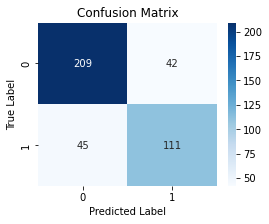

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       251
           1       0.73      0.71      0.72       156

    accuracy                           0.79       407
   macro avg       0.77      0.77      0.77       407
weighted avg       0.79      0.79      0.79       407



In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir las probabilidades en etiquetas binarias (0 o 1)
binary_predictions = (predictions > 0.0).astype(int) #############
# Obtener las etiquetas verdaderas de los datos de validación
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, binary_predictions)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(true_labels, binary_predictions))

### Plot the accuracy and loss over time


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


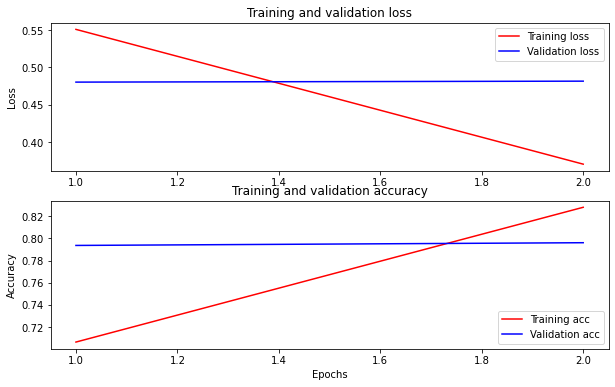

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [19]:
# Cargar el conjunto de datos test
test_data = pd.read_csv("test_nolabel.csv")

test_data

,text,id
0,Well media selected them exactly because they'...,ce40fcb3a33
1,We must stand together to return this mass of ...,02ca950343c
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05
...,...,...
3488,This political party were neo-nazis in the 90s...,c42316663f5
3489,You're fucking kidding me. I'm stupefied she i...,3e1b52d2030
3490,Instead of caricaturing the whole Muslim and I...,fe66fe0f5cc
3491,"sort out Is , and then they can go back!!!",3a5ca8a8fd5


In [20]:
test_data['clean_text'] = test_data['text']#.apply(preprocess_text)
test_data

,text,id,clean_text
0,Well media selected them exactly because they'...,ce40fcb3a33,Well media selected them exactly because they'...
1,We must stand together to return this mass of ...,02ca950343c,We must stand together to return this mass of ...
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c,http://apologeticspress.org/APContent.aspx?cat...
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38,"The UK has universal healthcare you dickwad, t..."
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05,Is that comment good for clergyman Paul Kosyl?
...,...,...,...
3488,This political party were neo-nazis in the 90s...,c42316663f5,This political party were neo-nazis in the 90s...
3489,You're fucking kidding me. I'm stupefied she i...,3e1b52d2030,You're fucking kidding me. I'm stupefied she i...
3490,Instead of caricaturing the whole Muslim and I...,fe66fe0f5cc,Instead of caricaturing the whole Muslim and I...
3491,"sort out Is , and then they can go back!!!",3a5ca8a8fd5,"sort out Is , and then they can go back!!!"


In [21]:
#Predicción
pred_new = classifier_model.predict(test_data["clean_text"])


110/110 [==============================] - 281s 3s/step


In [30]:
# Aplicar umbral para convertir las predicciones en etiquetas binarias
binary_predictions = (pred_new > 0.0).astype(int)

# Añadir las predicciones binarias al DataFrame
test_data['predicted_label'] = binary_predictions
pred_new

array([[ 3.4155633 ],
       [ 0.52277243],
       [-4.2913013 ],
       ...,
       [ 1.8103359 ],
       [ 0.1875029 ],
       [ 1.1494989 ]], dtype=float32)

In [31]:
predictions_df = pd.DataFrame({'id': test_data["id"], 'label': test_data['predicted_label']})

predictions_df.to_csv("bert_predictions.csv", index=False, header=True)
predictions_df

,id,label
0,ce40fcb3a33,1
1,02ca950343c,1
2,a59e88b4f9c,0
3,ad62d80af38,1
4,a6b36372f05,0
...,...,...
3488,c42316663f5,1
3489,3e1b52d2030,1
3490,fe66fe0f5cc,1
3491,3a5ca8a8fd5,1
